<a href="https://colab.research.google.com/github/alunfes/GoogleColabProjects/blob/main/DQN_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#%cp -rp '/content/drive/My Drive/ta-lib/' ~/
%cd ~
!rm -rf ta-lib*
#!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
#%cd '/content/drive/My Drive/ta-lib'
#%cd ta-lib
import os
#os.chdir('/content/drive/My Drive/ta-lib') # Can't use !cd in co-lab
os.chdir('ta-lib') # Can't use !cd in co-lab
#%cd ~/ta-lib
!./configure --prefix=/usr
#! '/content/drive/My Drive/ta-lib/configure' --prefix=/usr
!make
!make install
!pip install Ta-Lib
%cd /content

/root
--2023-12-29 06:26:50--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving sourceforge.net (sourceforge.net)... 172.64.150.145, 104.18.37.111, 2606:4700:4400::6812:256f, ...
Connecting to sourceforge.net (sourceforge.net)|172.64.150.145|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/ [following]
--2023-12-29 06:26:50--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/download [following]
--2023-12-29 06:26:51--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/download
Reusing existing connection to sourceforge.net:443.
HTTP request sent, aw

In [3]:
import pandas as pd
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import time
import datetime
import talib as ta
from collections import deque, namedtuple
from numba import jit

In [4]:
################################################################################
########################## Config ####################################
################################################################################
ohlc_directory = '/content/drive/My Drive/MarketData/ohlc'
model_directory = '/content/drive/My Drive/Model/'

In [5]:
################################################################################
########################## MarketData ####################################
################################################################################
class MarketData:
    @classmethod
    def initialize(cls, terms:list):
        cls.terms = terms
        cls.open = []
        cls.high = []
        cls.low = []
        cls.close = []
        cls.dt = []
        cls.ma_kairi = {} #term:ma_kairi
        cls.rsi = {} # 0 - 1.0
        cls.adx = {} #0.0 - 0.6
        cls.cci = {} #-1.0 - 1.0
        cls.cmo = {} #-1.0 - 1.0
        cls.dx = {} #0.0 - 1.0
        cls.minus_di = {} #0.0 - 1.0
        cls.plus_di = {} #0.0 - 1.0
        cls.rocr = {} #0.8 - 1.1
        cls.correl = {} #-1.0 - 1.0
        cls.__read_data()
        cls.__calc_all_index()


    @classmethod
    def __read_data(cls):
        df = pd.read_csv(ohlc_directory+'/bybit-USDT-BTC.csv')
        cls.open = df['open'].tolist()
        cls.high = df['high'].tolist()
        cls.low = df['low'].tolist()
        cls.close = np.array(df['close'].tolist())
        cls.dt = pd.to_datetime(df['timestamp'], unit='ms')  # Convert timestamp to datetime

    @classmethod
    def __calc_all_index(cls):
        for term in cls.terms:
            cls.ma_kairi[term] = cls.__calc_ma_kairi(term)
            cls.rsi[term] = cls.__calc_rsi(term)
            cls.adx[term] = cls.__calc_adx(term)
            cls.cci[term] = cls.__calc_cci(term)
            cls.cmo[term] = cls.__calc_cmo(term)
            cls.dx[term] = cls.__calc_dx(term)
            cls.minus_di[term] = cls.__calc_minus_di(term)
            cls.plus_di[term] = cls.__calc_plus_di(term)
            cls.rocr[term] = cls.__calc_rocr(term)
            cls.correl[term] = cls.__calc_correl(term)

    @classmethod
    def __calc_ma_kairi(cls, term):
        '''
        ma = pd.Series(cls.close).rolling(window=term).mean()  # 移動平均を計算
        ma_kairi = ((pd.Series(cls.close) - ma) / ma) * 100  # 乖離率を計算
        ma_kairi[:term] = np.nan  # 最初のterm要素をnanに設定
        return ma_kairi.tolist()
        '''
        # Calculate moving average using talib's SMA (Simple Moving Average) function
        ma = ta.SMA(np.array(cls.close, dtype='f8'), timeperiod=term)
        # Calculate the deviation (kairi) from the moving average
        ma_kairi = ((np.array(cls.close, dtype='f8') - ma) / ma) * 100
        return ma_kairi

    @classmethod
    def __calc_rsi(cls, term):
        return ta.RSI(np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_adx(cls, term):
        return ta.ADX(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_cci(cls, term):
        return ta.CCI(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term) / 1500

    @classmethod
    def __calc_cmo(cls, term):
        return ta.CMO(np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_dx(cls, term):
        return ta.DX(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_minus_di(cls, term):
        return ta.MINUS_DI(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_plus_di(cls, term):
        return ta.PLUS_DI(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_rocr(cls, term):
        return ta.ROCR100(np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_correl(cls, term):
        return ta.CORREL(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), timeperiod=term)

    '''
    @classmethod
    def generate_state(cls, current_index, state_length):
        # Ensure the index is within the valid range
        if current_index - state_length < 0 or current_index >= len(cls.close):
            raise ValueError("Invalid current_index for generating market data state.")
        # Extracting the state data
        state = {f'ma_kairi_{term}': np.array(cls.ma_kairi[term][current_index - state_length:current_index])
            for term in cls.terms}
        return state

    @classmethod
    def generate_state2(cls, current_index, desired_state_length, sampled_state_length):
        if current_index < desired_state_length or current_index >= len(cls.close):
            raise ValueError("Invalid current_index for generating market data state.")
        # 開始インデックスの計算
        start_index = max(0, current_index - desired_state_length)
        # 価格変動率の計算
        price_changes = np.diff(cls.close[start_index:current_index])
        change_rates = np.abs(price_changes / cls.close[start_index:current_index - 1])
        # 変動率に基づく重み付け
        weights = np.append(change_rates, [0])  # 最後に0を追加してサイズを合わせる
        weights /= weights.sum()  # 重みの合計が1になるように調整
        # 重みに基づいてサンプリング
        sampled_indices = np.random.choice(range(start_index, current_index), size=sampled_state_length, replace=False, p=weights)
        # サンプリングされたデータの抽出
        state = {f'ma_kairi_{term}': np.array([cls.ma_kairi[term][i] for i in sampled_indices])
                 for term in cls.terms}
        return state
    '''

    @classmethod
    def generate_state(cls, current_index):
        '''
        state = {}
        for term in cls.terms:
            # Fetching each indicator's value at the specified index
            state[f'ma_kairi_{term}'] = cls.ma_kairi[term][current_index] if current_index >= term else np.nan
            state[f'rsi_{term}'] = cls.rsi[term][current_index] if current_index >= term else np.nan
            state[f'adx_{term}'] = cls.adx[term][current_index] if current_index >= term else np.nan
            state[f'cci_{term}'] = cls.cci[term][current_index] if current_index >= term else np.nan
            state[f'cmo_{term}'] = cls.cmo[term][current_index] if current_index >= term else np.nan
            state[f'dx_{term}'] = cls.dx[term][current_index] if current_index >= term else np.nan
            state[f'minus_di_{term}'] = cls.minus_di[term][current_index] if current_index >= term else np.nan
            state[f'plus_di_{term}'] = cls.plus_di[term][current_index] if current_index >= term else np.nan
            state[f'rocr_{term}'] = cls.rocr[term][current_index] if current_index >= term else np.nan
            state[f'correl_{term}'] = cls.correl[term][current_index] if current_index >= term else np.nan
        return state
        '''
        state = []
        for term in cls.terms:
            # 各指標の値をリストに追加
            term_state = [
                cls.ma_kairi[term][current_index],
                cls.rsi[term][current_index],
                cls.adx[term][current_index],
                cls.cci[term][current_index],
                cls.cmo[term][current_index],
                cls.dx[term][current_index],
                cls.minus_di[term][current_index],
                cls.plus_di[term][current_index],
                cls.rocr[term][current_index],
                cls.correl[term][current_index],
            ]
            state.append(term_state)
        return state


MarketData.initialize([5, 15, 60, 120, 240, 720])

Step 0:Action type: 0, Asset Ratio: 1.00, Num Trades: 0, Win Rate: 0.00, Position: Side 0, Position Amount: 0.00, Total Asset: 10000.00, Free Cash: 10000.00, Total fee: 0.00, Lot 0.00, Unrealized PnL: 0.00, Total Realized PnL: 0.00
Step 1:Action type: 0, Asset Ratio: 1.00, Num Trades: 0, Win Rate: 0.00, Position: Side 0, Position Amount: 0.00, Total Asset: 10000.00, Free Cash: 10000.00, Total fee: 0.00, Lot 0.00, Unrealized PnL: 0.00, Total Realized PnL: 0.00
Step 2:Action type: 0, Asset Ratio: 1.00, Num Trades: 0, Win Rate: 0.00, Position: Side 0, Position Amount: 0.00, Total Asset: 10000.00, Free Cash: 10000.00, Total fee: 0.00, Lot 0.00, Unrealized PnL: 0.00, Total Realized PnL: 0.00
Step 3:Action type: 0, Asset Ratio: 1.00, Num Trades: 0, Win Rate: 0.00, Position: Side 0, Position Amount: 0.00, Total Asset: 10000.00, Free Cash: 10000.00, Total fee: 0.00, Lot 0.00, Unrealized PnL: 0.00, Total Realized PnL: 0.00
Step 4:Action type: 0, Asset Ratio: 1.00, Num Trades: 0, Win Rate: 0.00,

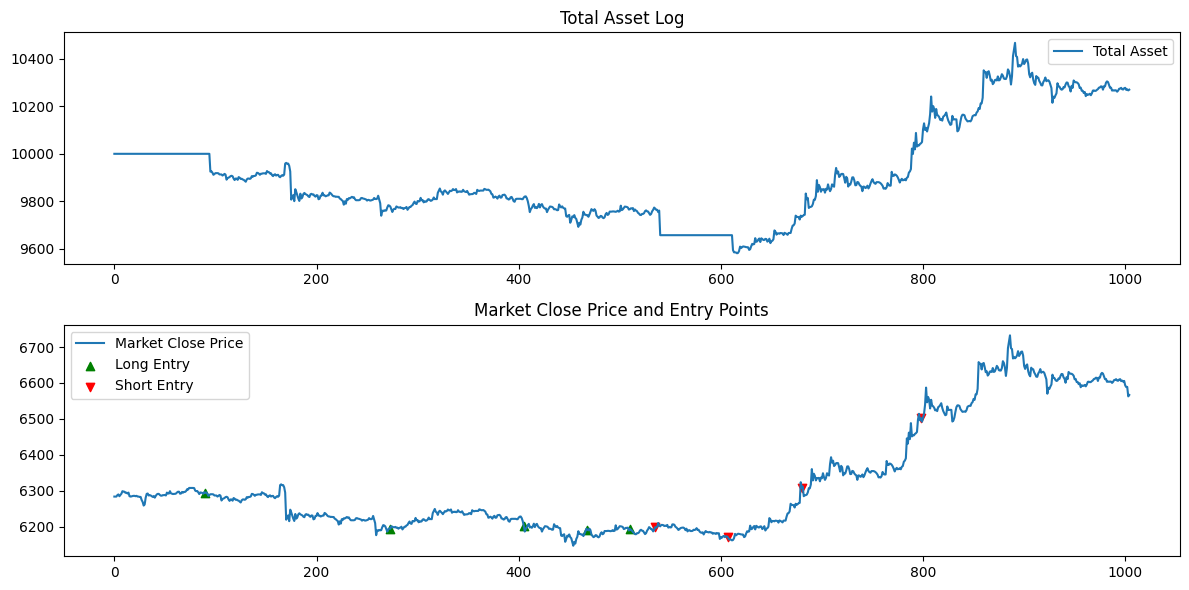

In [6]:
################################################################################
########################## Trading Env ####################################
'''
前提:
・order cash ratioを基準にしており、no posi or additional execの場合はfree cashを基準に、oppsite execの場合はposition lotを基準に計算する。ratioが0.99以上の場合は1.0として処理する。
また、ratioの最大値は1.0、よってfully exit and opposite entryはない前提

Actions:
0: no action
1:long market order
2:short market order

'''
################################################################################
class TradingEnv:
    def __init__(self, display_flg, start_ind, end_ind, state_length, is_done_pnl_ratio=-0.2, is_done_trade_ratio=6.9e-04, spread_ratio=0.0005, maker_fee_ratio=0.001,
                 taker_fee_ratio=0.007, effective_digits=2, reward_kijun_start_period = 60, reward_kijun_end_period = 120):
        self.display_flg = display_flg
        self.start_ind = start_ind
        self.end_ind = end_ind
        self.state_length = state_length
        self.is_done_pnl_ratio = is_done_pnl_ratio
        self.is_done_trade_ratio = is_done_trade_ratio
        self.initial_asset = 10000
        self.max_orders = 5
        self.spread_ratio = spread_ratio
        self.maker_fee_ratio = maker_fee_ratio
        self.taker_fee_ratio = taker_fee_ratio
        self.effective_digits = effective_digits
        self.reward_kijun_start_period = reward_kijun_start_period
        self.reward_kijun_end_period = reward_kijun_end_period
        self.reset()

    def __init_position(self):
        self.position_side = 0
        self.position_price = 0
        self.position_lot = 0
        self.position_entry_ind = 0


    def __get_position_size(self):
        return MarketData.close[self.start_ind + self.num_steps] * self.position_lot

    def __init_order(self):
        self.order_side = []
        self.order_price = []
        self.order_cash_ratio = [] #
        self.order_price_close_ratio = 0  # Order price / current price ratio
        self.order_amount_close_ratio = 0  # order amount / current price ratio

    def __init_performance(self):
        self.total_asset = self.initial_asset
        self.total_asset_change_ratio = 0
        self.free_cash = self.initial_asset
        self.total_fee = 0
        self.total_pnl = 0
        self.total_realized_pnl = 0
        self.unrealized_pnl = 0
        self.unrealized_pnl_ratio = 0
        self.position_amount_total_asset_ratio = 0
        self.num_trade = 0
        self.num_win = 0
        self.win_rate = 0
        self.total_asset_when_last_entry = 0

    def __init_log(self):
        self.total_asset_log = [self.initial_asset] * self.state_length
        self.free_cash_log = deque([self.initial_asset] * self.state_length, maxlen=self.state_length)
        self.total_pnl_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.total_realized_pnl_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.unrealized_pnl_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.unrealized_pnl_ratio_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.position_side_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.position_price_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.position_amount_total_asset_ratio_log = deque([0] * self.state_length, maxlen=self.state_length)


    def reset(self):
        self.num_steps = 0
        self.current_action_ind = -1
        self.__init_position()
        self.__init_order()
        self.__init_performance()
        self.__init_log()
        return self.__generate_state()



    def __check_is_done(self):
        if self.is_done_pnl_ratio > (self.total_asset - self.initial_asset) / self.initial_asset:
            if self.display_flg:
                print('Env is done due to asset change ratio criteria!')
                print('total asset=',self.total_asset, ', asset ratio=', (self.total_asset - self.initial_asset) / self.initial_asset)
            return True
        elif self.is_done_trade_ratio > (self.num_trade+1) / (self.num_steps+1):
            if self.display_flg:
                print('Env is done due to num trade per step criteria!')
                print('num trade=', self.num_trade, ', steps=', self.num_steps)
            return True
        else:
            return False

    def __calc_unrealized_pnl(self):
        unrealized_pnl = self.position_side * (MarketData.close[self.start_ind + self.num_steps] - self.position_price) * self.position_lot
        return unrealized_pnl

    def __update_performance(self):
        self.unrealized_pnl = self.__calc_unrealized_pnl()
        self.unrealized_pnl_ratio = 0 if self.unrealized_pnl == 0 else self.unrealized_pnl / self.total_asset_when_last_entry
        self.win_rate = 0 if self.num_trade == 0 else self.num_win / self.num_trade
        self.position_amount_total_asset_ratio = (self.position_lot * self.position_price) / self.total_asset
        self.total_asset = self.__calc_total_asset()  # Assuming there is a method __calc_total_asset
        self.total_asset_change_ratio = (self.total_asset - self.initial_asset) / self.initial_asset

    def __update_order_index(self):
        current_market_price = MarketData.close[self.start_ind + self.num_steps]
        self.order_price_close_ratio = np.array(self.order_price) / current_market_price
        # 注文数量（ロット）と市場価格の比率を計算
        # ここでの計算方法は、注文の数量をどのように管理しているかに依存します
        # 以下は、注文キャッシュ比率に基づいて数量を計算する一例です
        self.order_amount_close_ratio = np.array(self.order_lot) * current_market_price / self.total_asset

    def __take_log(self):
        self.total_asset_log.append(self.total_asset)
        self.free_cash_log.append(self.free_cash)
        self.total_pnl_log.append(self.total_pnl)
        self.total_realized_pnl_log.append(self.total_realized_pnl)
        self.unrealized_pnl_log.append(self.unrealized_pnl)
        self.unrealized_pnl_ratio_log.append(self.unrealized_pnl_ratio)
        self.position_side_log.append(self.position_side)
        self.position_price_log.append(self.position_price)
        self.position_amount_total_asset_ratio_log.append(self.position_amount_total_asset_ratio)


    def __generate_state(self):
        state = []
        #state['position_amount_total_asset_ratuo'] = np.array(self.position_amount_total_asset_ratio_log[-self.state_length])
        state.append(torch.tensor(np.array(list(self.position_side_log)[-self.state_length:]), dtype=torch.float32).tolist())
        state.append(torch.tensor(np.array(list(self.unrealized_pnl_ratio_log)[-self.state_length:]), dtype=torch.float32).tolist())
        # 他の特徴量があれば同様に追加
        #state['order_price_close_ratio'] = np.array(list(self.order_price_close_ratio) + [0] * (self.max_orders - len(self.order_price_close_ratio)))
        #state['order_amount_close_ratio'] = np.array(list(self.order_amount_close_ratio) + [0] * (self.max_orders - len(self.order_amount_close_ratio)))
        return state

    def __calc_reward_average_profit(self):
        if self.position_side == 0:
            return 0
        else:
            avep = sum(MarketData.close[self.start_ind + self.num_steps + self.reward_kijun_start_period : self.start_ind + self.num_steps + self.reward_kijun_end_period]) / (self.reward_kijun_end_period - self.reward_kijun_start_period)
            currentp = MarketData.close[self.start_ind + self.num_steps + self.reward_kijun_start_period]
            if self.spread_ratio + self.taker_fee_ratio <= self.position_side * (avep - currentp) / currentp:
                return 1
            else:
                return -1
    def __calc_reward_asset_gain_and_win_rate(self):
        asset_gain = (self.total_asset - self.initial_asset) / self.initial_asset
        win_rate_reward = 0
        if self.num_trade > 0:
            win_rate_reward = self.win_rate - 0.5  # 勝率が50%を超えるとプラス、未満だとマイナスになる
        reward = asset_gain + win_rate_reward
        return reward

    def __calc_sharpe_ratio(self):
        if len(self.total_asset_log) < 2:
            return 0
        asset_returns = [t / s - 1 for s, t in zip(self.total_asset_log[:-1], self.total_asset_log[1:])]
        mean_return = np.mean(asset_returns)
        std_dev = np.std(asset_returns)
        if std_dev == 0:
            return 0
        sharpe_ratio = mean_return / std_dev
        return sharpe_ratio

    def __calc_reward_risk_adjusted_return(self):
        sharpe_ratio = self.__calc_sharpe_ratio()
        return sharpe_ratio

    def __calc_reward_simple_asset_increase(self):
        if self.total_asset_log[-1] > self.total_asset_log[-2]:
            return 1
        else:
            return -1

    def __calc_reward_test(self):
        if self.position_side_log[-1] != self.position_side_log[-2]:
            return 1
        else:
            return -1


    def step(self, action_ind, action_ratio):
        self.__take_action(action_ind, action_ratio)
        is_done = self.__check_is_done()
        self.__update_performance()
        self.__take_log()
        self.num_steps += 1
        return is_done, self.__generate_state(), self.__calc_reward_simple_asset_increase()

    def __take_action(self, action_ind, action_ratio):
        if action_ind == self.current_action_ind:
            self.current_action_ind = action_ind
        if action_ind in [1, 2, 3, 4]:  # when long, short order
            otype = 'market' if action_ind in [1, 2] else 'limit'
            oside = 1 if action_ind in [1, 3] else -1
            oprice = self.__calc_best_bid_ask(oside)  # limit order price is fixed at best bid / ask
            ocash_ratio = round(max(min(action_ratio, 1.0), 0.01), self.effective_digits)
            self.__entry_order(otype, oside, oprice, ocash_ratio)
        elif action_ind == 5:  # exit all
            if self.position_side != 0:
                oside = 1 if self.position_side == -1 else -1
                exec_price = self.__calc_best_bid_ask(oside)
                self.__execute_order('market', oside, exec_price, 1.0)
        else:
            pass  # no action

    def __calc_best_bid_ask(self, oside):
    # Assuming MarketData is a class or structure with market data
    # and self.num_steps is the current step in the trading environment
        return MarketData.close[self.start_ind + self.num_steps] * (1.0 + self.spread_ratio) if oside == 1 else MarketData.close[self.start_ind + self.num_steps] * (1.0 - self.spread_ratio)

    def __entry_order(self, otype, oside, oprice, ocash_ratio):
        if ocash_ratio > 1.0:
            if self.display_flg:
                print('TradingEnv: new order refused as cash ratio exceeded 1.0!')
            return False
        if self.position_side == 0 or self.position_side == oside:
            if self.free_cash <= 0.01:
                if self.display_flg:
                    print('TradingEnv.entry_order: Insufficient free cash!', ', ocash_ratio=', ocash_ratio, ', price=', oprice, ', free_cash=', self.free_cash)
        if otype == 'market':
            exec_price = self.__calc_best_bid_ask(oside)
            self.__execute_order('market', oside, exec_price, ocash_ratio)
        else:
            self.__add_limit_order(oside, oprice, ocash_ratio)



    def __add_limit_order(self, oside, oprice, ocash_ratio):
        if len(self.order_side) < self.max_orders:
            self.order_side.append(oside)
            self.order_price.append(oprice)
            self.order_cash_ratio.append(ocash_ratio)
        else:
            if self.display_flg:
                print('TradingEnv: new order refused as it exceeds max order num!')


    def __check_execution(self):
        for oind in reversed(range(len(self.order_side))):
            order_executed = False  # 約定フラグ
            if self.order_side[oind] == 1:  # 買い注文
                if MarketData.low[self.start_ind + self.current_step] < self.order_price[oind]:
                    order_executed = True
                    self.__execute_order('limit', self.order_side[oind], self.order_price[oind], self.order_cash_ratio[oind])
            elif self.order_side[oind] == -1:  # 売り注文
                if MarketData.high[self.start_ind + self.current_step] > self.order_price[oind]:
                    order_executed = True
                    self.__execute_order('limit', self.order_side[oind], self.order_price[oind], self.order_cash_ratio[oind])
            else:
                print('TradingEnv.__check_execution: Invalid order side !', self.order_side[oind])
            if order_executed:
                del self.order_side[oind]
                del self.order_price[oind]
                del self.order_cash_ratio[oind]


    def __calc_realized_pnl(self, exec_price, exec_lot):
        return exec_lot * (exec_price - self.position_price) if self.position_side == 1 else exec_lot * (self.position_price - exec_price)

    def __calc_fee(self, otype, exec_price, exec_lot):
        fee = self.maker_fee_ratio * exec_price * exec_lot if otype == 'limit' else self.taker_fee_ratio * exec_price * exec_lot
        self.total_fee += fee
        return fee

    def __check_win_lose(self):
        if self.__calc_total_asset() > self.total_asset_when_last_entry:
            self.num_win += 1

    def __calc_total_asset(self):
        return self.__get_position_size() + self.free_cash


    def __exit_all(self, otype, exec_price):
        fee = self.__calc_fee(otype, exec_price, self.position_lot)
        self.free_cash = round(self.position_lot * exec_price - fee, self.effective_digits)
        self.total_realized_pnl += self.__calc_realized_pnl(exec_price, self.position_lot)
        self.num_trade += 1
        self.unrealized_pnl = 0
        self.__init_position()
        self.__check_win_lose()
        self.total_asset_when_last_entry = 0


    def __check_free_cash_amount(self, free_cash):
        if free_cash < 0:
            print('TradingEnv.check_free_cash_amount: Free cash amount should not be negative!', ', free cash=', free_cash)
            return False
        return True

    def __truncate_number(self, number, decimals=0):
        """
        任意の小数点以下の桁数で数値を切り捨てる関数

        :param number: 切り捨てる数値
        :param decimals: 保持する小数点以下の桁数（デフォルトは0）
        :return: 切り捨てられた数値
        """
        factor = 10 ** decimals
        return int(number * factor) / factor

    def __execute_order(self, otype, exec_side, exec_price, ocash_ratio):
        if self.position_side == 0 or self.position_side == exec_side: #new or additional execution
            if ocash_ratio > 0.99: #full entryとして処理
                ocash_ratio = 1.0
            tmp_amount = ocash_ratio * self.free_cash
            tmp_lot = tmp_amount / exec_price
            fee = self.__calc_fee(otype, exec_price, tmp_lot)
            lot = self.__truncate_number( (self.free_cash - fee) / exec_price, self.effective_digits)
            self.free_cash -= round(fee + lot * exec_price, self.effective_digits)
            if self.__check_free_cash_amount(self.free_cash) == False:
                print('tmp_amount=',tmp_amount, ', tmp_lot=',tmp_lot, ', fee=',fee, ', lot=',lot, ', exec_price=',exec_price)
            self.position_price = (self.position_price * self.position_lot + exec_price * lot) / (self.position_lot + lot)
            self.position_lot = self.position_lot + lot
            if self.position_side == 0:
                self.position_entry_ind = self.start_ind + self.num_steps
                self.position_side = exec_side
                self.total_asset_when_last_entry = self.__calc_total_asset()
        elif self.position_side != exec_side:#opposite execution, assumed exec lot is smaller than current position lot
            if ocash_ratio > 0.99: #exit allとして処理
                self.__exit_all(otype, exec_price)
            else:
                lot = self.__truncate_number(self.position_lot * ocash_ratio, self.effective_digits)
                if self.position_lot >= lot:
                    fee = self.__calc_fee(otype, exec_price, lot)
                    self.free_cash = round(self.free_cash - fee + lot * exec_price, self.effective_digits)
                    self.__check_free_cash_amount(self.free_cash)
                    self.position_lot -= lot
                    #calc realized pnl
                    self.total_realized_pnl += self.__calc_realized_pnl(exec_price, lot)
                else:
                    print('TradingEnv.execute_order: Opposite executed lot should be smaller than position lot!', ', lot=', lot, ', position lot=', self.position_lot)
        else:
            print('TradingEnv.execute_order: Invalid Situation!')



#Market Orderのテスト
# Initialize the trading environment
env = TradingEnv(display_flg=True, start_ind=10000, end_ind=len(MarketData.close)-1, state_length=5)
# Simulation parameters
total_steps = 1000
order_probability = 0.01
long_entries, short_entries = [], []  # To track entry points for plotting
# Execute actions at each step
for step in range(total_steps):
    action_type = 0
    if random.random() < order_probability:
        action_type = random.choice([1, 2])  # 1: Long Market Order, 2: Short Market Order
    action_ratio = 1.0 #random.uniform(0.1, 1.0)
    is_done, ac_state, reward = env.step(action_type, action_ratio)
    # Record entry points
    if action_type == 1:
        long_entries.append(step)
    elif action_type == 2:
        short_entries.append(step)
    # Display information per step
    print(f"Step {step}:Action type: {action_type}, Asset Ratio: {env.total_asset/env.initial_asset:.2f}, Num Trades: {env.num_trade}, Win Rate: {env.win_rate:.2f}, Position: Side {env.position_side}, Position Amount: {env.position_price * env.position_lot:.2f}, Total Asset: {env.total_asset:.2f}, Free Cash: {env.free_cash:.2f}, Total fee: {env.total_fee:.2f}, Lot {env.position_lot:.2f}, Unrealized PnL: {env.unrealized_pnl:.2f}, Total Realized PnL: {env.total_realized_pnl:.2f}")
    if is_done:
        print("Environment is done!")
        break



# Plotting
plt.figure(figsize=(12, 6))
# Plot total asset log
plt.subplot(2, 1, 1)
plt.plot(env.total_asset_log, label='Total Asset')
plt.legend()
plt.title('Total Asset Log')
# Plot MarketData.close with long and short entries
valid_close_data = MarketData.close[env.start_ind:env.start_ind + len(env.total_asset_log)]
plt.subplot(2, 1, 2)
plt.plot(valid_close_data, label='Market Close Price')
# long_entries と short_entries のクローズ価格を取得
long_close_prices = [MarketData.close[env.start_ind + i] for i in long_entries if env.start_ind + i < len(MarketData.close)]
short_close_prices = [MarketData.close[env.start_ind + i] for i in short_entries if env.start_ind + i < len(MarketData.close)]
# エントリポイントをプロット
plt.scatter(long_entries, long_close_prices, color='green', marker='^', label='Long Entry')
plt.scatter(short_entries, short_close_prices, color='red', marker='v', label='Short Entry')
plt.legend()
plt.title('Market Close Price and Entry Points')
plt.tight_layout()
plt.show()


In [7]:
##########################################################################################
################################# Replay Memory #######################################
##########################################################################################
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen = capacity)
        self. Transition = namedtuple('Transition', (
            'md_state',
            'md_next_state',
            'ac_state',
            'ac_next_state',
            'action',
            'reward',
            'is_done'))

    def push(self, *args):
        self.memory.append(self.Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def get_len(self):
        return len(self.memory)

In [68]:
################################################################################
######################## NN for MarketOrder only Strategy #############################
################################################################################
'''
Inputs:
・ma_kairi * terms
・Hist unrealized pnl ratio
・Hist position side

Outputs:
・0:No, 1:Long Market Order, 2:Short Market Order
'''
################################################################################
class DuelingDQNLayerNorm(nn.Module):
    def __init__(self, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size):
        super(DuelingDQNLayerNorm, self).__init__()
        self.num_md_out1 = int(md_state_length * 0.5)
        self.num_ac_out1 = int(ac_state_length * 0.5)
        self.num_md_in2 = int(self.num_md_out1 * md_state_num)
        self.num_md_out2 = int(self.num_md_out1 * md_state_num * 0.5)
        self.num_ac_in2 = int(self.num_ac_out1 * ac_state_num)
        self.num_ac_out2 = int(self.num_ac_out1 * ac_state_num * 0.5)
        self.num_pre_final_out = int(0.5*(self.num_md_out2 + self.num_ac_out2))
        # Add Layer Normalization layers for md and ac states
        self.md_layer_norms1 = nn.ModuleList([nn.LayerNorm(md_state_length) for _ in range(md_state_num)])
        self.ac_layer_norms1 = nn.ModuleList([nn.LayerNorm(ac_state_length) for _ in range(ac_state_num)])
        self.md_layer_norms2 = nn.ModuleList([nn.LayerNorm(self.num_md_out1) for _ in range(md_state_num)])
        self.ac_layer_norms2 = nn.ModuleList([nn.LayerNorm(self.num_ac_out1) for _ in range(ac_state_num)])
        self.md_con_layer_norm3 = nn.LayerNorm(self.num_md_out2)
        self.ac_con_layer_norm3 = nn.LayerNorm(self.num_ac_out2)
        self.all_con_layer_norm4 = nn.LayerNorm(self.num_md_out2 + self.num_ac_out2)
        self.all_con_layer_norm5 = nn.LayerNorm(self.num_pre_final_out)
        #first input layer for market data, account state
        self.md_linears1 = nn.ModuleList([nn.Linear(md_state_length, md_state_length) for _ in range(md_state_num)])
        self.ac_linears1 = nn.ModuleList([nn.Linear(ac_state_length, ac_state_length) for _ in range(ac_state_num)])
        #second layer that connect to concat layer for concatenations of each market data and account data
        self.md_linears2 = nn.ModuleList([nn.Linear(md_state_length, self.num_md_out1) for _ in range(md_state_num)])
        self.ac_linears2 = nn.ModuleList([nn.Linear(ac_state_length, self.num_ac_out1) for _ in range(ac_state_num)])
        #third layer, get input from concat layer
        self.md_con_linears3 = nn.Linear(self.num_md_in2, self.num_md_out2)
        self.ac_con_linears3 = nn.Linear(self.num_ac_in2, self.num_ac_out2)
        #forth layer that conect to concat layer for concatenations of concatnated market data and account data
        self.all_con_linears4 = nn.Linear(self.num_md_out2 + self.num_ac_out2, self.num_md_out2 + self.num_ac_out2)
        #fifth layer
        self.all_con_linears5 = nn.Linear(self.num_md_out2 + self.num_ac_out2, self.num_pre_final_out)
        #value layer
        self.value = nn.Linear(self.num_pre_final_out, 1)
        #advantage
        self.advantage = nn.Linear(self.num_pre_final_out, output_size)


    def forward(self, md_state, ac_state):
        '''
        # First layer processing
        md_out = [F.relu(linear(md)) for md, linear in zip(md_state, self.md_linears1)]
        ac_out = [F.relu(linear(ac)) for ac, linear in zip(ac_state, self.ac_linears1)]
        # Second layer
        md_out = [F.relu(linear(md)) for md, linear in zip(md_out, self.md_linears2)]
        ac_out = [F.relu(linear(ac)) for ac, linear in zip(ac_out, self.ac_linears2)]
        '''
        # First layer processing with Layer Normalization
        md_out = [F.relu(norm(linear(md))) for md, linear, norm in zip(md_state, self.md_linears1, self.md_layer_norms1)]
        ac_out = [F.relu(norm(linear(ac))) for ac, linear, norm in zip(ac_state, self.ac_linears1, self.ac_layer_norms1)]
        print('md_out0=', md_out.size())
        print('ac_out0=', ac_out.size())
        # Second layer
        md_out = [F.relu(norm(linear(md))) for md, linear, norm in zip(md_out, self.md_linears2, self.md_layer_norms2)]
        ac_out = [F.relu(norm(linear(ac))) for ac, linear, norm in zip(ac_out, self.ac_linears2, self.ac_layer_norms2)]
        print('md_out1=', md_out.size())
        print('ac_out1=', ac_out.size())
        # Concatenate and second layer processing
        md_out = torch.cat(md_out, dim=1)
        ac_out = torch.cat(ac_out, dim=1)
        md_out = torch.flatten(md_out)
        ac_out = torch.flatten(ac_out)
        md_out = F.relu(self.md_con_layer_norm3(self.md_con_linears3(md_out)))
        ac_out = F.relu(self.ac_con_layer_norm3(self.ac_con_linears3(ac_out)))
        # Concatenate and third layer processing
        all_concat = torch.cat([md_out, ac_out], dim=0)
        all_concat = torch.flatten(all_concat)
        all_concat = F.relu(self.all_con_layer_norm4(self.all_con_linears4(all_concat)))
        all_concat = F.relu(self.all_con_layer_norm5(self.all_con_linears5(all_concat)))
        value = self.value(all_concat)
        advantages = self.advantage(all_concat)
        q_values = value + (advantages - advantages.mean())
        return q_values


In [8]:
class DuelingDQN(nn.Module):
    def __init__(self, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size):
        super(DuelingDQN, self).__init__()
        self.md_state_num = md_state_num
        self.ac_state_num = ac_state_num
        self.num_md_out1 = int(md_state_length * 0.5)
        self.num_ac_out1 = int(ac_state_length * 0.5)
        self.num_md_in2 = int(self.num_md_out1 * md_state_num)
        self.num_md_out2 = int(self.num_md_out1 * md_state_num * 0.5)
        self.num_ac_in2 = int(self.num_ac_out1 * ac_state_num)
        self.num_ac_out2 = int(self.num_ac_out1 * ac_state_num * 0.5)
        self.num_pre_final_out = int(0.5 * (self.num_md_out2 + self.num_ac_out2))
        # Layers
        self.md_linears1 = nn.ModuleList([nn.Linear(md_state_length, md_state_length) for _ in range(md_state_num)])
        self.ac_linears1 = nn.ModuleList([nn.Linear(ac_state_length, ac_state_length) for _ in range(ac_state_num)])
        self.md_linears2 = nn.ModuleList([nn.Linear(md_state_length, self.num_md_out1) for _ in range(md_state_num)])
        self.ac_linears2 = nn.ModuleList([nn.Linear(ac_state_length, self.num_ac_out1) for _ in range(ac_state_num)])
        self.md_con_linears3 = nn.Linear(self.num_md_in2, self.num_md_out2)
        self.ac_con_linears3 = nn.Linear(self.num_ac_in2, self.num_ac_out2)
        self.all_con_linears4 = nn.Linear(self.num_md_out2 + self.num_ac_out2, self.num_md_out2 + self.num_ac_out2)
        self.all_con_linears5 = nn.Linear(self.num_md_out2 + self.num_ac_out2, self.num_pre_final_out)
        # Value and Advantage layers
        self.value = nn.Linear(self.num_pre_final_out, 1)
        self.advantage = nn.Linear(self.num_pre_final_out, output_size)
        # Apply He initialization
        for i in range(md_state_num):
            nn.init.kaiming_uniform_(self.md_linears1[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.md_linears2[i].weight, nonlinearity='relu')
        for i in range(ac_state_num):
            nn.init.kaiming_uniform_(self.ac_linears1[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.ac_linears2[i].weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.md_con_linears3.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.ac_con_linears3.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.all_con_linears4.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.all_con_linears5.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.value.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.advantage.weight, nonlinearity='relu')


    def forward(self, md_state, ac_state):
        md_out_list = []
        for i in range(self.md_state_num):
            md = md_state[:, i, :]
            md_out = F.relu(self.md_linears1[i](md))
            md_out_list.append(md_out)
        md_out = torch.stack(md_out_list, dim=1)
        ac_out_list = []
        for i in range(self.ac_state_num):
            ac = ac_state[:, i, :]
            ac_out = F.relu(self.ac_linears1[i](ac))
            ac_out_list.append(ac_out)
        ac_out = torch.stack(ac_out_list, dim=1)
        # Second layer processing
        md_out_list = []
        for i in range(self.md_state_num):
            md = md_out[:, i, :]
            md_out_new = F.relu(self.md_linears2[i](md))
            md_out_list.append(md_out_new)
        md_out = torch.stack(md_out_list, dim=1)
        ac_out_list = []
        for i in range(self.ac_state_num):
            ac = ac_out[:, i, :]
            ac_out_new = F.relu(self.ac_linears2[i](ac))
            ac_out_list.append(ac_out_new)
        ac_out = torch.stack(ac_out_list, dim=1)
        # Concatenate and further processing
        md_out = torch.flatten(md_out, start_dim=1)
        ac_out = torch.flatten(ac_out, start_dim=1)
        md_out = F.relu(self.md_con_linears3(md_out))
        ac_out = F.relu(self.ac_con_linears3(ac_out))
        all_concat = torch.cat([md_out, ac_out], dim=1)
        all_concat = F.relu(self.all_con_linears4(all_concat))
        all_concat = F.relu(self.all_con_linears5(all_concat))
        # Value and Advantage calculation
        value = self.value(all_concat)
        advantages = self.advantage(all_concat)
        q_values = value + (advantages - advantages.mean())
        return q_values


In [ ]:
class Agent:
    def __init__(self, load_model, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size, learning_rate=1e-03, BUFFER_SIZE=500000, BATCH_SIZE=1024, UPDATE_EVERY=128,
                 GAMMA=0.98, TAU=0.005, sim_start_ind_scope=[10000, 300000], max_sim_length=1000000, is_done_pnl_ratio=-0.2, is_done_trade_ratio = 6.9e-04, reward_kijun_start_period = 60, reward_kijun_end_period = 120):
        self.model_path = model_directory+'dqn_trading_model.pth'
        self.md_state_length = md_state_length
        self.md_state_num = md_state_num
        self.ac_state_length = ac_state_length
        self.ac_state_num = ac_state_num
        self.output_size = output_size
        # Rainbow DQNネットワーク（ローカルとターゲット）
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.qnetwork_local = DuelingDQN(self.md_state_length, self.md_state_num, self.ac_state_length, self.ac_state_num, self.output_size).to(self.device)
        self.qnetwork_target = DuelingDQN(self.md_state_length, self.md_state_num, self.ac_state_length, self.ac_state_num, self.output_size).to(self.device)
        if load_model:
            if os.path.isfile(self.model_path):
                self.__load_model()
                print("Loaded model weights from:", self.model_path)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=learning_rate)
        self.UPDATE_EVERY = UPDATE_EVERY
        self.GAMMA = GAMMA
        self.TAU = TAU
        # Prioritized Experience Replayメモリ（容量100000）
        self.BATCH_SIZE = BATCH_SIZE
        self.sim_start_ind_scope = sim_start_ind_scope
        self.max_sim_length = max_sim_length
        self.is_done_pnl_ratio = is_done_pnl_ratio
        self.is_done_trade_ratio = is_done_trade_ratio
        self.reward_kijun_start_period = reward_kijun_start_period
        self.reward_kijun_end_period = reward_kijun_end_period
        self.memory = ReplayMemory(BUFFER_SIZE)
        self.t_step = 0


    def __load_model(self):
        self.qnetwork_local.load_state_dict(torch.load(self.model_path, map_location=self.device))
        self.qnetwork_local.eval()  # 推論モードに設定
        self.qnetwork_target.load_state_dict(torch.load(self.model_path, map_location=self.device))
        self.qnetwork_target.eval()


    def step(self, md_state, md_next_state, ac_state, ac_next_state, action, reward, is_done):
        # 経験をメモリに保存
        self.memory.push(md_state, md_next_state, ac_state, ac_next_state, action, reward, is_done)
        # 学習間隔ごとに学習
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:
            # メモリからランダムな経験と学習
            if self.memory.get_len() > self.BATCH_SIZE:
                experiences = self.memory.sample(self.BATCH_SIZE)
                self.learn(experiences, self.GAMMA)

    def act(self, md_state, ac_state, eps=0.):
        # Epsilon-greedyによる行動選択
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(md_state, ac_state)
        self.qnetwork_local.train()
        # Epsilon-greedyポリシー
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.output_size))

    def learn(self, experiences, gamma):
        batch = self.memory.Transition(*zip(*experiences))
        #md_state, md_next_state, ac_state, ac_next_state, action, reward, is_done = experiences
        #md_state = torch.tensor(list(md_state.values()),dtype=torch.float64).float().unsqueeze(0)
        #md_next_state = torch.tensor(list(md_next_state.values()),dtype=torch.float64).float().unsqueeze(0)
        # Double DQNの更新ターゲット
        md_next_state = torch.tensor(batch.md_next_state, dtype=torch.float32).to(self.device)
        md_state = torch.tensor(batch.md_state, dtype=torch.float32).to(self.device)
        ac_next_state = torch.tensor(batch.ac_next_state, dtype=torch.float32).to(self.device)
        ac_state = torch.tensor(batch.ac_state, dtype=torch.float32).to(self.device)
        is_done = torch.tensor(batch.is_done, dtype=torch.float32).unsqueeze(1).to(self.device)
        reward = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(self.device)
        action = torch.tensor(batch.action, dtype=torch.float32).to(self.device)
        Q_targets_next = self.qnetwork_target(md_next_state, ac_next_state).detach().max(1)[0].unsqueeze(1)
        Q_targets = reward + (gamma * Q_targets_next * (1 - is_done))
        # 予想されるQ値を取得
        action = action.long().unsqueeze(1)  # action を int64 型に変換し、次元を追加
        Q_expected = self.qnetwork_local(md_state, ac_state).gather(1, action)
        # 損失を計算し、バックプロパゲーション
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # ターゲットネットワークを更新
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.TAU)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def train(self, n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
        scores = []                        # 各エピソードのスコアを保存するリスト
        scores_window = deque(maxlen=100)  # 最後の100スコア
        eps = eps_start                    # Epsilonの初期値
        for i_episode in range(1, n_episodes+1):
            start_time = time.perf_counter()  # エピソードの開始時刻
            random_sim_start = random.randint(self.sim_start_ind_scope[0], self.sim_start_ind_scope[1])
            env = TradingEnv(False, start_ind=random_sim_start, end_ind=random_sim_start + self.max_sim_length, state_length=self.ac_state_length, is_done_pnl_ratio=self.is_done_pnl_ratio,
                       is_done_trade_ratio=self.is_done_trade_ratio, reward_kijun_start_period = self.reward_kijun_start_period, reward_kijun_end_period = self.reward_kijun_end_period)
            ac_state = env.reset()            # 環境をリセットして初期状態を取得
            score = 0
            for t in range(self.max_sim_length):
                md_state = MarketData.generate_state(random_sim_start + t)
                md_next_state = MarketData.generate_state(random_sim_start + t+1)
                action = self.act(torch.tensor(md_state, dtype=torch.float32).unsqueeze(0).to(self.device), torch.tensor(ac_state, dtype=torch.float32).unsqueeze(0).to(self.device), eps)
                is_done, ac_next_state, reward,  = env.step(action, 1.0)
                self.step(md_state, md_next_state, ac_state, ac_next_state, action, reward, is_done)
                ac_state = ac_next_state
                score += reward
                if is_done:
                    break
            scores_window.append(score)       # 最新のスコアを保存
            scores.append(score)              # スコアをリストに追加
            eps = max(eps_end, eps_decay*eps) # Epsilonを減衰させる
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                end_time = time.perf_counter()   # エピソードの終了時刻
                episode_duration = end_time - start_time  # エピソードにかかった時間
                print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}\tNum Steps: {env.num_steps}\tNum Trade: {env.num_trade}\tWin Rate: {env.win_rate}\tAsset Change Ratio: {env.total_asset_change_ratio:.2f}\tDuration: {episode_duration:.2f} sec')
                torch.save(self.qnetwork_local.state_dict(), self.model_path)
        return scores



# 学習パラメータの設定
load_model = True
ac_state_length = 4
num_md_index = 10
md_state_length = num_md_index
max_sim_length = 1000000
is_done_pnl_ratio = -0.2
is_done_trade_ratio = 6.9e-04
reward_kijun_start_period = 60
reward_kijun_end_period = 90
n_episodes = 20000
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995

agent = Agent(load_model, md_state_length, md_state_num=len(MarketData.terms), ac_state_length=ac_state_length, ac_state_num=2, output_size=3, learning_rate=1e-03, BUFFER_SIZE=500000, BATCH_SIZE=1024, UPDATE_EVERY=128,
                 GAMMA=0.98, TAU=0.005, sim_start_ind_scope=[10000, 300000], max_sim_length=1000000, is_done_pnl_ratio=is_done_pnl_ratio, is_done_trade_ratio = is_done_trade_ratio,
              reward_kijun_start_period = reward_kijun_start_period, reward_kijun_end_period = reward_kijun_end_period)

# 学習の実行
scores = agent.train(n_episodes, eps_start, eps_end, eps_decay)

# 学習の進捗をグラフで表示
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Loaded model weights from: /content/drive/My Drive/Model/dqn_trading_model.pth
Episode 100	Average Score: -34.40	Num Steps: 38	Num Trade: 11	Win Rate: 0.0	Asset Change Ratio: -0.2027699999999999	Duration: 0.0748753547668457 sec
Episode 200	Average Score: -36.91	Num Steps: 93	Num Trade: 11	Win Rate: 0.0	Asset Change Ratio: -0.213337	Duration: 0.255739688873291 sec
Episode 300	Average Score: -38.95	Num Steps: 128	Num Trade: 12	Win Rate: 0.0	Asset Change Ratio: -0.20609499999999997	Duration: 0.31450891494750977 sec
Episode 400	Average Score: -42.57	Num Steps: 25	Num Trade: 10	Win Rate: 0.0	Asset Change Ratio: -0.21205550000000004	Duration: 0.033270835876464844 sec
Episode 500	Average Score: -54.27	Num Steps: 67	Num Trade: 11	Win Rate: 0.0	Asset Change Ratio: -0.21167699999999995	Duration: 0.22073578834533691 sec
Episode 600	Average Score: -56.19	Num Steps: 195	Num Trade: 11	Win Rate: 0.0	Asset Change Ratio: -0.20518199999999998	Duration: 0.3320145606994629 sec
Episode 700	Average Score: -